In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [56]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [32]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [33]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Train",
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 600 files belonging to 2 classes.


In [34]:
class_names = dataset.class_names
class_names

['no', 'yes']

In [35]:
len(dataset)

19

In [36]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


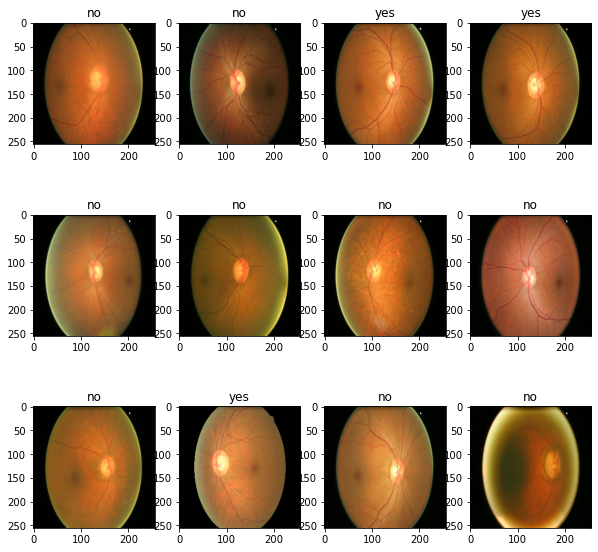

In [37]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
#         plt.axis("off")

In [38]:
def get_partition_dataset_tf(ds, train_split = 0.8, test_split = 0.2, shuffle = True, shuffle_size = 1000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)

    
    train_ds = ds.take(train_size)
    
    test_ds = ds.skip(train_size)
    
    return train_ds, test_ds 

In [39]:
train_ds, test_ds = get_partition_dataset_tf(dataset)

In [42]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [44]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [45]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape,),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [46]:
model.compile(
    optimizer="adam",
    loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ["accuracy"]
)

In [47]:
history = model.fit(
    train_ds,
    epochs= 50,
    batch_size= BATCH_SIZE,
    verbose=1
)

Epoch 1/50
15/15 [==============================] - 27s 1s/step - loss: 0.5836 - accuracy: 0.7083
Epoch 2/50
15/15 [==============================] - 23s 2s/step - loss: 0.5617 - accuracy: 0.7542
Epoch 3/50
15/15 [==============================] - 22s 1s/step - loss: 0.5615 - accuracy: 0.7542
Epoch 4/50
15/15 [==============================] - 21s 1s/step - loss: 0.5699 - accuracy: 0.7542
Epoch 5/50
15/15 [==============================] - 22s 1s/step - loss: 0.5600 - accuracy: 0.7542
Epoch 6/50
15/15 [==============================] - 22s 1s/step - loss: 0.5621 - accuracy: 0.7542
Epoch 7/50
15/15 [==============================] - 21s 1s/step - loss: 0.5636 - accuracy: 0.7542
Epoch 8/50
15/15 [==============================] - 21s 1s/step - loss: 0.5515 - accuracy: 0.7542
Epoch 9/50
15/15 [==============================] - 21s 1s/step - loss: 0.5566 - accuracy: 0.7542
Epoch 10/50
15/15 [==============================] - 22s 1s/step - loss: 0.5549 - accuracy: 0.7542
Epoch 11/50
15/15 [

In [48]:
model.save('model.h5')

In [53]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [60]:
# Load and preprocess the image for prediction
image = load_img('Image.jpg', target_size=(256, 256))
image_array = img_to_array(image)
image_array = image_array.reshape((1,) + image_array.shape)  # wrap in a batch
image_array /= 255.0  # normalize pixel values

# Make a prediction with the model
prediction = model.predict(image_array)

# Print the prediction
print(prediction)
print("--------->>>",class_names[np.argmax(prediction)])


1/1 [==============================] - 0s 67ms/step
[[0.44874367 0.55125636]]
--------->>> yes
